# HW1 : Regression, Cross-Validation, and  Regularization

In [1]:
import os
import numpy as np
import pandas as pd
 
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model


In [2]:
from matplotlib import pyplot as plt

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')


### Configuration

We assume your current directory contains folder 'data_auto'

To make this happen, before you run the notebook, be sure you have
* updated your local copy of the cs135-23f-assignments repo 
* cd into the hw1 dir

In [3]:
SEED = 12345 

DATA_DIR = 'data_auto'


In [4]:
# If running in cloud on Google colab, this code will acquire necessary data files
if os.getenv("COLAB_RELEASE_TAG") and not os.path.exists(DATA_DIR):
    !git clone https://github.com/tufts-ml-courses/cs135-23f-assignments.git
    os.chdir(os.path.join('cs135-23f-assignments', 'hw1'))
if not os.path.exists(DATA_DIR):
    raise ValueError("Need to run this script within a valid checkout of the cs135 repo")


### Methods for loading dataset

In [5]:
def load_2d_arr_from_csv(fname, include_header=False):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    assert x.ndim == 2
    if include_header:
        header_cols = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', dtype=str)[0].tolist()
        return x, header_cols
    else:
        return x
    
def load_1d_arr_from_csv(fname):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    if x.ndim == 1:
        return x
    else:
        raise ValueError("Not 1d")


# Load the dataset

Predefined 'x' and 'y' arrays for train/valid/test

In [6]:
x_tr_MF, xcolnames_F = load_2d_arr_from_csv('x_train.csv', include_header=True)
x_va_NF = load_2d_arr_from_csv('x_valid.csv')
x_te_PF = load_2d_arr_from_csv('x_test.csv')


In [7]:
print(xcolnames_F)


['horsepower', 'weight', 'cylinders', 'displacement']


In [8]:
print(x_tr_MF[:5])


[[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 [ 105. 3897.    6.  250.]
 [ 193. 4732.    8.  304.]]


In [9]:
y_tr_M = load_1d_arr_from_csv('y_train.csv')
y_va_N = load_1d_arr_from_csv('y_valid.csv')
y_te_P = load_1d_arr_from_csv('y_test.csv')


In [10]:
print(y_tr_M[:5,np.newaxis])


[[28.8]
 [16.5]
 [14. ]
 [16. ]
 [ 9. ]]


In [11]:
y_tr_M.max()


46.6

In [12]:
Y_MAX = 60.0


## Load completed code

In [13]:
from performance_metrics import calc_root_mean_squared_error
from cross_validation import train_models_and_calc_scores_for_n_fold_cv


## Define useful plotting functions

In [14]:
def plot_train_and_valid_error_vs_hyper(
        hyper_list, err_tr_list=None, err_va_list=None,
        ymax=40,
        leg_loc='upper right',
        xlabel='polynomial degree',
        ylabel='RMSE'):
    if err_va_list is not None:
        plt.plot(hyper_list, err_va_list, 'rs-', label='valid')
    if err_tr_list is not None:
        plt.plot(hyper_list, err_tr_list, 'bd:', label='train')
    plt.ylim([0, ymax])
    plt.legend(loc=leg_loc)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


## Method to sanitize predictions

We are predicting MPG, which should 
* (1) always be positive, and
* (2) will probably never exceed 120% of the largest value we see in train data

In [15]:
def sanitize(yhat_N):
    yhat_N = np.maximum(yhat_N, 0)
    yhat_N = np.minimum(yhat_N, Y_MAX)
    return yhat_N


In [16]:
bad_yhat_N = np.asarray([-10, -1, 0, 1, 5, 10, 50, 55, 60, 65])


In [17]:
bad_yhat_N


array([-10,  -1,   0,   1,   5,  10,  50,  55,  60,  65])

In [18]:
sanitize(bad_yhat_N)


array([ 0.,  0.,  0.,  1.,  5., 10., 50., 55., 60., 60.])

## Methods for building pipelines

In [19]:
def make_poly_linear_regr_pipeline(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline


In [20]:


def make_poly_ridge_regr_pipeline(degree=1, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline
     


## Methods to inspect learned weights

In [21]:

def pretty_print_learned_weights(pipeline, xcolnames_F):
    ''' Print the learned parameters of given pipeline
    '''
    my_lin_regr = pipeline.named_steps['linear_regr']

    feat_names = pipeline.named_steps['poly_transformer'].get_feature_names_out()
    coef_values = my_lin_regr.coef_

    for feat, coef in zip(feat_names, coef_values):
        print("% 7.2f : %s" % (coef, feat))
    
    print("where ")
    for ff, colname in enumerate(xcolnames_F):
        print("x%d = %s" % (ff, colname))
     


## Problem 1: Polynomial Degree Selection on Fixed Validation Set

In [64]:
degree_list = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list = []
fv_err_va_list = []

fv_pipeline_list = []
for degree in degree_list:

    pipeline = sklearn.pipeline.Pipeline(
        steps=[
            ('rescaler', sklearn.preprocessing.MinMaxScaler()),
            ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
            ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])

    pipeline.fit(x_tr_MF, y_tr_M)

    # Compute training error
    yhat_tr_M = sanitize(pipeline.predict(x_tr_MF))
    yhat_va_N = sanitize(pipeline.predict(x_va_NF))

    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M)
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N)

    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)
    
    fv_pipeline_list.append(pipeline)


### Figure 1: Error vs degree

Text(0.5, 1.0, 'RMSE vs. Degree')

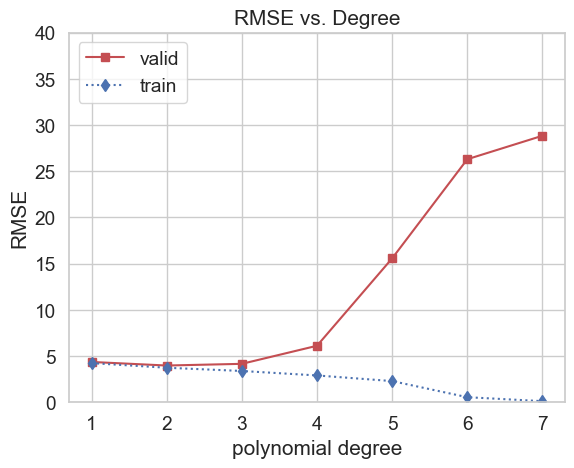

In [65]:
plot_train_and_valid_error_vs_hyper(
    degree_list, fv_err_tr_list, fv_err_va_list, leg_loc='upper left')
plt.title('RMSE vs. Degree')


### Implementation 1B: Score on the test set using the chosen model

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained LinearRegression model with these best hyperparameters, compute error on the *test* set. Save this test set error value for later.

In [24]:
print("Selected Parameters:")
print(f"degree={np.argmin(fv_err_va_list) + 1}")
print("Fixed validation set estimate of heldout error:")
print(np.min(fv_err_va_list))
print("Error on the test-set:")
pline = fv_pipeline_list[np.argmin(fv_err_va_list)]
yhat_te_P = sanitize(pline.predict(x_te_PF))
te_err = calc_root_mean_squared_error(yhat_te_P, y_te_P)
print(te_err)


Selected Parameters:
degree=2
Fixed validation set estimate of heldout error:
3.974075330754534
Error on the test-set:
3.99150254645676


In [25]:
score = te_err


### Short Answer 1a in Report

Investigate why preprocessing is necessary

In [26]:
# WRITE THIS IN YOUR REPORT, NOT IN THIS NOTEBOOK


### Short Answer 1b in Report

Consider the model with degree 1. 
Following the starter code, print out the values of **all** the learned weight parameters (aka coefficients).

In [27]:
# def pretty_print_learned_weights(pipeline):
#     feat_names = xcolnames_F
#     for ff in range(len(feat_names)):
#         coef_val_ff = pipeline.named_steps['linear_regr'].coef_[ff]
#         if np.allclose(coef_val_ff, 0):
#             coef_val_ff = 0.0
#         print(f"{feat_names[ff]:13}: {coef_val_ff:7.3f}")
            
#     print(f"Intercept    : {pipeline.named_steps['linear_regr'].intercept_:7.3f}")

pretty_print_learned_weights(fv_pipeline_list[0], xcolnames_F)


 -10.43 : x0
 -18.23 : x1
  -1.15 : x2
   0.58 : x3
where 
x0 = horsepower
x1 = weight
x2 = cylinders
x3 = displacement


### Short Answer 1c in Report

Consider the models with degree 3 or 4. 
Inspect the learned weight parameters, including the number of parameters and their relative magnitudes.

What do you notice about these values compared to the values with degree 1 or 2?
How might what you notice be connected to the trends in training and validation set performance you observe in Figure 1?

In [28]:
pretty_print_learned_weights(fv_pipeline_list[2], xcolnames_F)
print("-=-=-=-=-")
pretty_print_learned_weights(fv_pipeline_list[3], xcolnames_F)


 -51.31 : x0
  -0.19 : x1
 -71.52 : x2
  -1.51 : x3
  -6.50 : x0^2
 -89.63 : x0 x1
 111.51 : x0 x2
 154.55 : x0 x3
 -24.89 : x1^2
 273.68 : x1 x2
-324.89 : x1 x3
 232.32 : x2^2
-729.76 : x2 x3
 619.52 : x3^2
 -25.77 : x0^3
-525.15 : x0^2 x1
 109.24 : x0^2 x2
 533.34 : x0^2 x3
 550.23 : x0 x1^2
-721.22 : x0 x1 x2
 937.28 : x0 x1 x3
-108.35 : x0 x2^2
 570.59 : x0 x2 x3
-1485.19 : x0 x3^2
 109.45 : x1^3
-167.95 : x1^2 x2
-517.84 : x1^2 x3
 -71.97 : x1 x2^2
 797.23 : x1 x2 x3
-212.40 : x1 x3^2
-294.17 : x2^3
 1077.75 : x2^2 x3
-1696.77 : x2 x3^2
 1025.55 : x3^3
where 
x0 = horsepower
x1 = weight
x2 = cylinders
x3 = displacement
-=-=-=-=-
 617.45 : x0
-191.08 : x1
 1774.24 : x2
-1343.56 : x3
 159.25 : x0^2
-323.66 : x0 x1
-5179.64 : x0 x2
 198.45 : x0 x3
  61.37 : x1^2
 2573.25 : x1 x2
-1596.95 : x1 x3
-5943.40 : x2^2
 7359.52 : x2 x3
 2883.15 : x3^2
-630.58 : x0^3
 1377.51 : x0^2 x1
-1600.47 : x0^2 x2
 1529.25 : x0^2 x3
-105.12 : x0 x1^2
-7880.76 : x0 x1 x2
 12085.95 : x0 x1 x3
 13051.50 :

# Problem 2: Alpha Selection on Fixed Val Set

In [29]:
my_degree = 4
alpha_list = np.asarray([1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04, 1.e+06])
print(alpha_list)


[1.e-10 1.e-08 1.e-06 1.e-04 1.e-02 1.e+00 1.e+02 1.e+04 1.e+06]


In [30]:
fv2_err_tr_list = []
fv2_err_va_list = []
fv2_pipeline_list = []

for alpha in alpha_list:

    pipeline = make_poly_ridge_regr_pipeline(my_degree, alpha)
    
    pipeline.fit(x_tr_MF, y_tr_M)

    yhat_tr_M = sanitize(pipeline.predict(x_tr_MF))
    yhat_va_N = sanitize(pipeline.predict(x_va_NF))
    assert np.all(yhat_va_N >= 0.0)
    assert np.all(yhat_va_N <= Y_MAX)
    
    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M)
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N)

    fv2_err_tr_list.append(err_tr)
    fv2_err_va_list.append(err_va)

    fv2_pipeline_list.append(pipeline)


### Figure 2 in report

Make a line plot of mean-squared error on y-axis vs. alpha on x-axis.

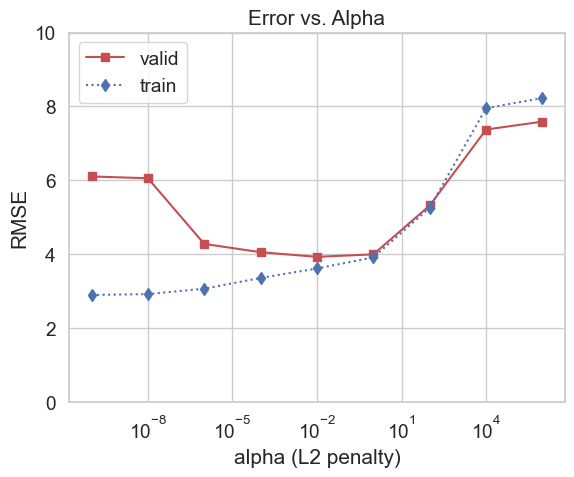

In [31]:
plot_train_and_valid_error_vs_hyper(
    alpha_list, fv2_err_tr_list, fv2_err_va_list,
    xlabel='alpha (L2 penalty)', leg_loc='upper left');
plt.gca().set_ylim([0, 10]);
plt.gca().set_xscale('log');
plt.title('Error vs. Alpha');


### Implementation Step 2B

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained model with these best hyperparameters, compute error on the *test* set. 


In [32]:
print("Selected Parameters:")
best_pipeline_idx = np.argmin(fv2_err_va_list)
print(f"alpha={alpha_list[best_pipeline_idx]}")
print("Fixed validation set estimate of heldout error:")
print(f"err_va={fv2_err_va_list[best_pipeline_idx]:.4f}")
print("Error on the test-set:")

yhat_te_P = fv2_pipeline_list[best_pipeline_idx].predict(x_te_PF)
err_te = calc_root_mean_squared_error(y_te_P, yhat_te_P)

print(f"err_te={err_te:.4f}")


Selected Parameters:
alpha=0.01
Fixed validation set estimate of heldout error:
err_va=3.9314
Error on the test-set:
err_te=3.8777


In [33]:
score2 = err_te


### Short Answer 2a in Report

Inspect the learned weight parameters of your chosen degree-4 model.
What do you notice about the relative magnitudes compared to 1c above?

In [34]:
pretty_print_learned_weights(fv2_pipeline_list[best_pipeline_idx], xcolnames_F)


 -39.88 : x0
   1.56 : x1
  14.71 : x2
 -13.32 : x3
  -6.53 : x0^2
  -5.93 : x0 x1
  21.96 : x0 x2
  24.36 : x0 x3
 -22.82 : x1^2
   2.39 : x1 x2
  -2.18 : x1 x3
 -19.42 : x2^2
 -26.81 : x2 x3
   3.47 : x3^2
   9.93 : x0^3
   5.41 : x0^2 x1
   9.37 : x0^2 x2
  14.07 : x0^2 x3
   8.22 : x0 x1^2
   7.41 : x0 x1 x2
  12.85 : x0 x1 x3
   0.12 : x0 x2^2
  -1.49 : x0 x2 x3
   0.97 : x0 x3^2
  -5.93 : x1^3
  -2.12 : x1^2 x2
  -2.79 : x1^2 x3
   0.19 : x1 x2^2
  -2.80 : x1 x2 x3
  -0.49 : x1 x3^2
  -4.76 : x2^3
  -3.17 : x2^2 x3
   3.10 : x2 x3^2
   5.33 : x3^3
   5.15 : x0^4
  -4.71 : x0^3 x1
  -1.87 : x0^3 x2
   5.64 : x0^3 x3
  -2.97 : x0^2 x1^2
  -5.04 : x0^2 x1 x2
   1.79 : x0^2 x1 x3
 -10.96 : x0^2 x2^2
  -4.93 : x0^2 x2 x3
  -3.79 : x0^2 x3^2
   4.44 : x0 x1^3
   2.40 : x0 x1^2 x2
   5.23 : x0 x1^2 x3
  -4.37 : x0 x1 x2^2
  -0.25 : x0 x1 x2 x3
  -1.68 : x0 x1 x3^2
 -16.61 : x0 x2^3
 -11.02 : x0 x2^2 x3
 -10.19 : x0 x2 x3^2
 -13.04 : x0 x3^3
   2.39 : x1^4
   3.05 : x1^3 x2
   0.24 : x1^

# Data preprocessing for Problem 3

For this problem, you'll again use the provided training set and validation sets. However, you'll *merge* these into a large "development" set that contains 292 examples total.

In [35]:
x_trva_LF = np.vstack([x_tr_MF, x_va_NF])
y_trva_L = np.hstack([y_tr_M, y_va_N])

print(x_trva_LF.shape)


(292, 4)


# Problem 3: Cross Validation for Polynomial Feature Regression

### Implementation step 3A

For each possible `alpha` value as well as each possible polynomial degree, train and evaluate a `Ridge` regression model across the entire train+validation set using 10-fold cross validation. Use the CV methods you implemented in `cross_validation.py`. For each possible hyperparameter (alpha value and degree value), your 10-fold CV procedure will give you an estimate of the training error and heldout validation error (averaged across all folds). 


In [45]:
K = 10 # num folds of CV
degree_list = [1, 2, 3, 4, 5, 6, 7]
alpha_list = np.logspace(-10, 6, 17)

ridge_param_list = []
for alpha in alpha_list:
    for degree in degree_list:
        ridge_param_list.append(dict(degree=degree, alpha=alpha))
        
cv_train_err_list = []
cv_valid_err_list = []
for param in ridge_param_list:
    pipeline = make_poly_ridge_regr_pipeline(**param)
    tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv(pipeline, x_trva_LF, y_trva_L, K, SEED)

    err_tr = np.average(tr_error_K)
    err_va = np.average(valid_error_K)
    
    cv_train_err_list.append(err_tr)
    cv_valid_err_list.append(err_va)


### Implementation step 3B

Select the model hyperparameters that *minimize* your estimated cross-validation error. Using these best hyperparameters, retrain the model using the full development set (concatenating the predefined training and validation sets). Then compute that (retrained) model's error on the test set.

Save this test set error value for later.

In [50]:
best_model_idx = np.argmin(cv_valid_err_list)
pipeline = make_poly_ridge_regr_pipeline(**ridge_param_list[best_model_idx])
pipeline.fit(x_trva_LF, y_trva_L)
yhat_te_P = pipeline.predict(x_te_PF)
score3 = calc_root_mean_squared_error(y_te_P, yhat_te_P)


In [51]:
print("Selected Parameters:")
print(ridge_param_list[best_model_idx])
print("10-fold CV estimate of heldout error:")
print(cv_valid_err_list[best_model_idx])
print("Error on the test-set:")
print(score3)


Selected Parameters:
{'degree': 7, 'alpha': 0.1}
10-fold CV estimate of heldout error:
3.859947335404448
Error on the test-set:
3.816826761080231


## Table 3 : Comparing pipelines on test set

In [71]:
class DumbRegressor:
    def __init__(self):
        self.y_mean = np.infty

    def fit(self, _x_NF, y_N):
        self.y_mean = np.mean(y_N)
    def predict(self, x_NF):
        N, F = x_NF.shape
        return np.full(N, self.y_mean)

dr = DumbRegressor()
dr.fit(x_tr_MF, y_tr_M)
yhat_te_P = dr.predict(x_te_PF)
dumb_score = calc_root_mean_squared_error(y_te_P, yhat_te_P)

print(f"Dumb Baseline error : {dumb_score:.3f}")
print(f"Linear_reg error    : {score:.3f}")
print(f"Set Poly_reg error  : {score2:.3f}")
print(f"CV Poly_reg error   : {score3:.3f}")


Dumb Baseline error : 7.104
Linear_reg error    : 3.992
Set Poly_reg error  : 3.878
CV Poly_reg error   : 3.817
